In [1]:
%pip install pandas

Note: you may need to restart the kernel to use updated packages.


最大值为3.756279927401098, 此时x为1.7614858260019552, y为-2.0


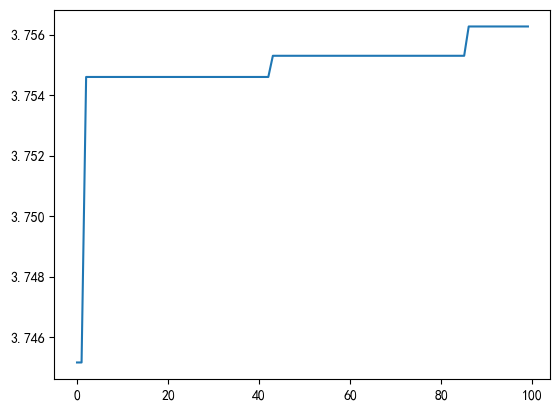

In [2]:
import math
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation as animation
import copy

# 定义算法的全局变量
POP_NUM = 500  # 初始种群数
CROSS_RATE = 0.7  # 交叉率
VARIATION_RATE = 0.01  # 变异率
EPOCH = 100  # 迭代轮数
GENE_LEN = 20

# 将个体分解为xy
def get_xy(individual):
    x = []
    y = []
    for i, k in enumerate(individual):
        if i%2==0: x.append(k)
        else: y.append(k)
    xd = int("".join(map(str, x)), 2)/1023*4-2
    yd = int("".join(map(str, y)), 2)/1023*4-2
    return xd, yd

def cal_func(individual):
    xd, yd = get_xy(individual)
    return xd * math.cos(2 * math.pi * yd) + yd * math.sin(2 * math.pi * xd)

# 定义适应性函数
def get_fitness(pop):
    fitness = [cal_func(individual) + 100 for individual in pop]
    return fitness

# 初始化种群
def init_population():
    pop = list(np.random.randint(0,2,(POP_NUM,GENE_LEN))) 
    return pop

def choose(pop, fitness):
    selected = []
    for _ in range(POP_NUM):
        weights = fitness / np.sum(fitness)  
        index = np.random.choice(np.arange(len(pop)), p=weights) 
        selected.append(pop[index])
    selected = selected + pop
    selected = sorted(selected, key=lambda p: cal_func(p), reverse=True)[:POP_NUM]
    return selected   

# 交叉操作
def cross(pop):
    new_population = []
    for _ in range(POP_NUM):
        if CROSS_RATE > np.random.random():
            index1, index2 = np.random.choice(range(POP_NUM), 2, replace=False)
            parent1 = pop[index1]
            parent2 = pop[index2]

            # parent随机交换基因
            child1 = copy.deepcopy(parent1)
            child2 = copy.deepcopy(parent2)
            change_index = np.random.choice(range(GENE_LEN), 10, replace=False)
            for index in change_index:
                child1[index] = parent2[index]
                child2[index] = parent1[index]
            
            new_population.append(child1)
            new_population.append(child2)
    new_population = new_population + pop
    new_population = sorted(new_population, key=lambda p: cal_func(p), reverse=True)
    return new_population

# TODO: 变异操作, 反转两点
def mutation(pop):
    pop_ = copy.deepcopy(pop)
    for i in range(POP_NUM):
        if np.random.random() < VARIATION_RATE:
            point1,point2 = np.random.choice(range(GENE_LEN), 2, replace=False)
            pop[i][point1], pop[i][point2] = pop[i][point2], pop[i][point1]
    pop = pop_ + pop
    pop = sorted(pop, key=lambda p: cal_func(p), reverse=True)[:POP_NUM]
    return pop

# 计算最大值
def calc_max_val(pop):
    max_val = -0x3f3f3f3f
    xy = list()
    for individual in pop:
        val = cal_func(individual)
        if val > max_val:  # 更新最大值和相应的xy
            max_val = val
            xy = individual
    return max_val, xy

# 画图初始化（显示中文）
plt.rcParams['font.sans-serif']=['SimHei']

# 程序入口
if __name__ == '__main__':
    pop = init_population()  # 初始化种群
    max_val_change = []  # 记录每一个epoch对应的最短距离和路径
    for epoch in range(EPOCH):
        fitness = get_fitness(pop)  # 一个种群的适应度
        nxt_pop = choose(pop, fitness)  # 进行种群选择
        nxt_pop = cross(nxt_pop)  # 对种群进行交叉
        nxt_pop = mutation(nxt_pop)  # 对种群进行变异
        max_val = calc_max_val(nxt_pop)  # 计算种群的最短距离和路径
        pop = nxt_pop  # 更新到下一代
        max_val_change.append(max_val)  # 存储记录
    max_xy = max_val_change[-1][1]
    x, y = get_xy(max_val_change[-1][1])

    print(f"最大值为{max_val_change[-1][0]}, 此时x为{x}, y为{y}")

    plt.plot([x[0] for x in max_val_change])
    plt.show()

In [3]:
class GA:
    def __init__(self, fitness, seed=0, pop_size=100, num_genes=20, mutation_rate=0.05, cross_rate=0.7, max_iter=100):
        self.fitness = fitness
        self.pop_size = pop_size
        self.num_genes = num_genes
        self.mutation_rate = mutation_rate
        self.cross_rate = cross_rate
        self.max_iter = max_iter

        np.random.seed(seed=seed)


    def __call__(self):
        pop = self.init(self.pop_size, self.num_genes)

        fitl = []
        best_keep = []

        for _ in range(self.max_iter):
            ppop = []

            self.selection(pop)  # init self.pl

            for _ in range(self.pop_size):
                v = self.selection(pop, mute=False)
                ppop.append(v)

            pop = ppop
            ppop = []
            self.selection(pop)  # init self.pl
            for _ in range(self.pop_size // 2):
                r = np.random.random()

                v1 = self.selection(pop, mute=False)
                v2 = self.selection(pop, mute=False)
                if r < self.cross_rate:
                    vv1, vv2 = self.crossover(v1, v2)
                    ppop.append(vv1)
                    ppop.append(vv2)
                else:
                    ppop.append(v1)
                    ppop.append(v2)

            if self.pop_size % 2:
                ppop.append(self.selection(pop, mute=False))

            for v in ppop:
                v = self.mutate(v)

            pop = ppop
            pop = sorted(pop, key=lambda v: self.fitness(*self.decoder(v)), reverse=True)

            vbest = pop[0]
            xbest, ybest = self.decoder(vbest)
            fbest = self.fitness(xbest, ybest)
            best_keep.append(vbest)

            fitl.append(fbest)

        pop = best_keep
        pop = sorted(pop, key=lambda v: self.fitness(*self.decoder(v)), reverse=True)

        vbest = pop[0]
        xbest, ybest = self.decoder(vbest)

        return vbest, fitl

    def init(self, pop_size=100, num_genes=20):
        pop = [np.random.randint(0, 2, num_genes) for _ in range(pop_size)]
        return pop
    
    def decoder(self, v):
        decx = v[0:len(v)//2]
        decy = v[len(v)//2:]

        # decx = []
        # decy = []
        # for i in range(len(v)):
        #     if i%2 == 0:
        #         decx.append(v[i])
        #     else:
        #         decy.append(v[i])
                
        x = np.dot(np.array([2**i for i in range(len(decx))]), decx)
        y = np.dot(np.array([2**i for i in range(len(decy))]), decy)

        # scale to [-2, 2]
        dx = 2**(len(decx) - 1)
        x = (x - dx) / (dx) * 2
        dy = 2**(len(decy) - 1)
        y = (y - dy) / (dy) * 2
        return x, y

    def selection(self, pop, mute=True):
        if mute:
            fl = []
            for v in pop:
                x, y = self.decoder(v)
                f = self.fitness(x, y)
                fl.append(f)

            fl = np.array(fl)
            fl = np.exp(fl)
            fl = fl / np.sum(fl)  # softmax

            self.pl = [np.sum(fl[:i]) for i in range(len(fl))]

        r = np.random.random()
        for i in range(len(self.pl)):
            if self.pl[i] > r:
                return pop[i]
        
        return pop[-1]
                    
    def crossover(self, v1, v2):
        r = np.random.randint(0, self.num_genes)
        vv1 = np.zeros(self.num_genes)
        vv2 = np.zeros(self.num_genes)

        vv1[:r] = v1[:r]
        vv1[r:] = v2[r:]

        vv2[:r] = v2[:r]
        vv2[r:] = v1[r:]

        return vv1, vv2

    def mutate(self, v):
        for i in range(self.num_genes):
            if np.random.random() < self.mutation_rate:
                v[i] = np.random.randint(0, 2)

        return v


In [34]:
def fitness(X, Y):
    return X*np.cos(2*np.pi*Y) + Y*np.sin(2*np.pi*X)

[1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(1.76171875, -2.0)
3.7562996633573804
3.7563359221353894


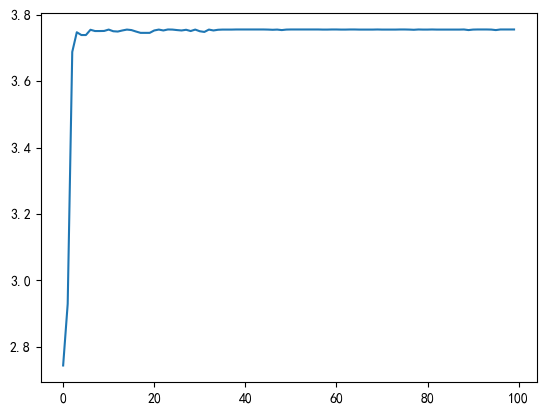

In [58]:
GAr = None

vb = None
vf = None
cost = -np.inf
for _ in range(1):
    GAr = GA(fitness=fitness, seed=np.random.randint(0, 100000), pop_size=500, mutation_rate=0.05, cross_rate=0.7, max_iter=100, num_genes=20)
    vbest, fitl = GAr()
    ccost = fitness(*GAr.decoder(vbest))

    if ccost > cost:
        vb = vbest
        vf = fitl
        cost = ccost

print(vb)
print(GAr.decoder(vb))
print(cost)
print(f'{fitness(1.76267854, -2)}')
plt.plot(range(len(vf)), vf)
plt.show()